<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Monte-Carlo-Simulationen:-Maximum-Sharpe,--Minimum-Variance-und-Value-at-Risk" data-toc-modified-id="Monte-Carlo-Simulationen:-Maximum-Sharpe,--Minimum-Variance-und-Value-at-Risk-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Monte-Carlo Simulationen: Maximum Sharpe,  Minimum Variance und Value-at-Risk</a></span><ul class="toc-item"><li><span><a href="#Download" data-toc-modified-id="Download-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Download</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Simulation</a></span></li><li><span><a href="#Betrachtung-der-Ergebnisse" data-toc-modified-id="Betrachtung-der-Ergebnisse-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Betrachtung der Ergebnisse</a></span></li></ul></li></ul></div>

Willkommen zur zweiten Case-Study. Diese beinhaltet Aufgaben zu den Notebooks C.1 und insbesondere C.2. Nach der Installation aller relevanten Pakete beschäftigen wir uns mit optimalen Portfolios. Mittels einer Monte-Carlo Simulation finden wir die Portfolios mit der maximalen Sharpe-Ratio, der minimalen Varianz und dem minimalen Value-at-Risk für unsere Beispielaktien. Dabei implementieren wir auch Short-Selling.

Achten Sie darauf, dass Ihr Code in einem Setting läuft (Kernel > Restart & Run All).

Bitte nutzen Sie die vorgesehenen Felder für Ihren Code und Ihre Antworten. Es gibt neun Code-Felder und drei Fragen. 

Zusätzlich zur Abgabe dieses Notebooks geben Sie bitte das Excel-Sheet mit Ihren Lösungen ab. Benennen Sie das Excel und das Notebook bitte nach dem Prinzip: Case2_Nachname_Vorname.

HAPPY CODING!

Tragen Sie in der folgenden Markdown Zeile den Namen Ihres Teampartners ein bzw. im Falle einer Einzelarbeit bitte dies vermerken.

> Götz Dennis

Tragen Sie in der folgenden Markdown Zeile Ihre Matrikelnummer ein.

 > 272753

**Installation aller relevanten Pakete:**

In [2]:
import pandas as pd  
import numpy as np
import pandas_datareader.data as web
from datetime import datetime
import scipy.optimize as sco
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

# Monte-Carlo Simulationen: Maximum Sharpe,  Minimum Variance und Value-at-Risk

## Download

Wir erstellen ein Portfolio aus sechs Aktien für den Zeitraum vom 01.01.2018 - 31.12.2021. Die Aktien haben die Ticker ['MMM', 'TSLA', 'CSCO', 'V', 'GE', 'AMZN'].
Laden Sie bitte den Adjusted Close für die Aktien und speichern Sie sie in einem DataFrame *df*. Index sollte das Datum sein, die Spaltennamen die Ticker.

In [8]:
#download stock portfolio data
tickers = ['MMM', 'TSLA', 'CSCO', 'V', 'GE', 'AMZN']
start = datetime(2018, 1, 1)
end = datetime(2021, 12, 31)

df = pd.DataFrame([web.get_data_yahoo(ticker, start, end)['Adj Close'] for ticker in tickers]).T
df.columns = tickers
df

,MMM,TSLA,CSCO,V,GE,AMZN
Date,,,,,,
2018-01-02,199.068909,21.368668,33.400402,110.811295,132.421585,59.450500
2018-01-03,199.060471,21.150000,33.666851,111.914474,133.673599,60.209999
2018-01-04,201.662460,20.974667,33.762108,112.330589,136.472290,60.479500
2018-01-05,203.233795,21.105333,34.229687,115.020805,136.545990,61.457001
2018-01-08,202.574814,22.427334,34.584721,115.485275,134.631042,62.343498
...,...,...,...,...,...,...
2021-12-27,169.512512,364.646667,61.489910,215.996124,94.305313,169.669495
2021-12-28,170.414276,362.823334,61.596565,216.412964,94.983055,170.660995
2021-12-29,171.152969,362.063324,62.013485,216.532059,94.474754,169.201004


**Frage 1:** Wie heißen die Unternehmen?

MMM = 3M Company <br>
TSLA = Tesla, Inc. <br>
CSCO = Cisco Systems, Inc. <br>
V = Visa, Inc. <br>
GE = General Electric Company <br>
AMZN = Amazon.com, Inc

## Simulation

Für unsere Portfoliooptimierung wollen wir die Monte-Carlo Simulation aus der Vorlesung in zwei Punkten verändern. 
1. Wir wollen nun mittels einer Monte-Carlo Simulation direkt **drei** Portfolios ermitteln: Das mit der optimalen Sharpe-Ratio, das mit der minimalen Varianz und das mit dem minimalen Value-at-Risk. 
2. Wir wollen in unserer Simulation auch Short-Selling ermöglichen. 

Analog zur Vorgehensweise im Noteboook C.2 erstellen wir zuerst eine Funktion, *calc_portfolio_perf*, mit den Eingabeparametern *weights, mean_returns, cov, rf, alpha, days*. Die Funktion berechnet mithilfe der Eingabeparameter für ein Portfolio die Rendite, Standardabweichung, Sharpe-Ratio und den Value-at-Risk für den Zeitraum days. Die Funktion hat entsprechend die Ausgabeparameter *portfolio_return, portfolio_std, sharpe_ratio, portfolio_VaR*. 

In [19]:
# Definition calc_portfolio_perf

def calc_portfolio_perf(weights, mean_returns, cov, rf, alpha, days, short):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, sharpe_ratio, portfolio_var

Nun erstellen wir die Funktion *simulate_random_portfolios* mit den Eingabeparametern *num_portfolios, mean_returns, cov, rf, alpha, days, short*. Neu für Sie ist vor allem der Eingabeparameter *short*. Er kann die String-Werte 'yes' und 'no' annehmen. Die Funktion simuliert dann entweder Portfolios mit oder ohne Short-Selling. 

Die Funktion gibt ein DataFrame *results_df* mit den Spalten *portfolio_return, portfolio_std, sharpe_ratio, portfolio_VaR* und den jeweiligen Gewichten der Aktien aus. 

Wir generieren analog zur Vorlesung als erstes die leere *results_matrix*. Im zweiten Schritt fragen wir mit einer If-Abfrage ab, ob Short-Selling implementiert werden soll. Wenn *no* können wir die *results_matrix* analog zur Vorlesung definieren. Wenn *yes* müssen wir auch negative Gewichte zulassen. Die wichtigste Veränderung des Codes im Vergleich zur Vorlesung geschieht also im Vektor *weights*. Die Gewichte müssen jetzt im Intervall [-1;1] liegen. Je nach If-Abfrage wird ein anderes *results_df* generiert.

Eine Implementierungshilfe zu den Gewichten für das Short-Selling: Wir wollen jetzt auch negative Gewichte zulassen. Um die Ergebnisse etwas einzuschränken sollen die Zahlen nun zwischen -1 und 1 liegen. Dafür kann man die Funktion np.random.randint nutzen. Um von Integer auf Dezimahlzahlen mit fünf Nachkommastellen zwischen -1 und 1 zu kommen, müssen Sie eine entsprechende Division durchführen.


In [31]:
# simulate_random_portfolios

def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf, alpha, days, short):
    results_matrix = np.zeros((len(mean_returns)+4, num_portfolios))
    for i in range(num_portfolios):
        if short == 'no':
            weights = np.random.random(len(mean_returns))
            weights /= np.sum(weights)
        elif short == 'yes':
            while True:
                weights = np.random.uniform(low = -1,high = 1,size = 5)
                if 1-np.sum(weights) <= 1 and 1-np.sum(weights) >= -1:
                    weights = np.insert(weights, 0, [1-np.sum(weights)])
                    break
        portfolio_return, portfolio_std, sharpe_ratio, portfolio_var = calc_portfolio_perf(weights, mean_returns, cov, rf, alpha, days, short)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        results_matrix[3,i] = portfolio_var
        #iterate through the weight vector and add data
        for j in range(len(weights)):
            results_matrix[j+4,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['portfolio_return', 'portfolio_std', 'sharpe_ratio', 'portfolio_var'] + [ticker for ticker in tickers])
        
    return results_df

Führen Sie anhand der Funktion *simulate_random_portfolios* bitte zwei Simulationen durch und speichern Sie die Ergebnisse in DataFrames. Simulieren Sie jeweils 100,000 Portfolios. In der ersten Simulation gibt es kein Short-Selling. Nennen Sie das DataFrame *results_frame_l* (l = long). In der zweiten Simulation gibt es  Short-Selling. Nennen Sie das DataFrame *results_frame_s* (s = short). Setzen Sie *rf* = 0, *days* = 252 und *alpha* = 0.05. 

Tipp: Damit Sie nicht solange warten müssen, können Sie zum ausprobieren ja auch ein wesentlich kleineres Portfolio nutzen.

In [34]:
#ohne shortselling 

mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0
days = 252
alpha = 0.05
short = 'no'

results_frame_l = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf, alpha, days, short)
results_frame_l

,portfolio_return,portfolio_std,sharpe_ratio,portfolio_var,MMM,TSLA,CSCO,V,GE,AMZN
0,0.282529,0.263774,1.071102,0.151341,0.231701,0.185025,0.071771,0.310795,0.090861,0.109847
1,0.377113,0.284735,1.324436,0.091234,0.076984,0.245345,0.197631,0.243968,0.029565,0.206508
2,0.305769,0.263332,1.161157,0.127373,0.052962,0.142673,0.186096,0.449240,0.021094,0.147935
3,0.147098,0.252970,0.581483,0.269001,0.267519,0.047124,0.191214,0.147001,0.242095,0.105047
4,0.200121,0.236720,0.845391,0.189248,0.346279,0.079945,0.043241,0.213306,0.077453,0.239776
...,...,...,...,...,...,...,...,...,...,...
99995,0.241011,0.240211,1.003331,0.154101,0.219312,0.077913,0.110263,0.324676,0.003352,0.264485
99996,0.358058,0.298256,1.200504,0.132530,0.057775,0.260846,0.156232,0.082323,0.219973,0.222851
99997,0.132281,0.267702,0.494134,0.308050,0.133635,0.006929,0.164362,0.405458,0.274243,0.015372
99998,0.260575,0.266408,0.978105,0.177627,0.177187,0.161304,0.068352,0.198302,0.215211,0.179644


In [35]:
#mit shortselling

mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0
days = 252
alpha = 0.05
short = 'yes'

results_frame_s = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf, alpha, days, short)
results_frame_s

,portfolio_return,portfolio_std,sharpe_ratio,portfolio_var,MMM,TSLA,CSCO,V,GE,AMZN
0,-0.049860,0.469912,-0.106106,0.822797,-0.475537,-0.265979,0.202336,0.375025,0.979621,0.184533
1,0.963806,0.613397,1.571259,0.045143,-0.635257,0.782241,0.064444,0.508117,-0.152730,0.433186
2,-0.092725,0.483112,-0.191933,0.887375,0.531193,-0.466063,0.569192,0.990284,-0.721228,0.096622
3,0.759221,0.474587,1.599751,0.021405,-0.577160,0.517957,0.426598,0.291232,-0.126716,0.468090
4,-0.473934,0.522426,-0.907181,1.333248,0.637367,-0.749476,0.146509,0.071786,0.368110,0.525704
...,...,...,...,...,...,...,...,...,...,...
99995,0.273181,0.422201,0.647041,0.421277,-0.891449,-0.151892,0.735877,-0.216443,0.540901,0.983006
99996,0.082986,0.299663,0.276931,0.409916,0.496543,-0.086504,-0.444798,-0.128236,0.278060,0.884935
99997,0.096118,0.280870,0.342217,0.365871,0.706348,0.095562,-0.177710,-0.178785,0.304834,0.249750
99998,0.669387,0.576206,1.161715,0.278388,0.929510,0.701273,0.277337,0.154866,-0.937897,-0.125089


## Betrachtung der Ergebnisse 

Für *results_frame_l* und *results_frame_s* wollen wir jeweils das Portfolio mit der höchsten Sharpe-Ratio, der niedrigsten Standardabweichung und dem minimalen Value-at-Risk finden. Diese wollen wir in einem DataFrame *portfolios* speichern. Extrahieren Sie die gesuchten Zeilen aus *results_frame_l* und *results_frame_s* (z.B. mit *iloc*) und speichern Sie die sechs Zeilen in einem DataFrame *portfolios* (z.B. mit append oder pd.concat). *portfoliosP soll dieselben Spaltenbezeichnungen haben wie *results_frame_l* und *results_frame_s*. Der Index nummeriert die Spalten des DataFrames beginnend mit Null.


In [50]:
#Position des Portfolios mit höchster sharp ratio

max_sharpe_port_l = results_frame_l.iloc[results_frame_l['sharpe_ratio'].idxmax()]
max_sharpe_port_s = results_frame_s.iloc[results_frame_s['sharpe_ratio'].idxmax()]

#Position des Portfolios mit geringster std

min_vol_port_l = results_frame_l.iloc[results_frame_l['portfolio_std'].idxmin()]
min_vol_port_s = results_frame_s.iloc[results_frame_s['portfolio_std'].idxmin()]

#Position des Portfolios mit minimalem var

min_VaR_port_l = results_frame_l.iloc[results_frame_l['portfolio_var'].idxmin()]
min_VaR_port_s = results_frame_s.iloc[results_frame_s['portfolio_var'].idxmin()]

#Aus jeder Liste ein Dataframe erstellen
max_sharpe_port_l_t = max_sharpe_port_l.to_frame().T
max_sharpe_port_s_t = max_sharpe_port_s.to_frame().T
min_vol_port_l_t = min_vol_port_l.to_frame().T
min_vol_port_s_t = min_vol_port_s.to_frame().T
min_VaR_port_l_t = min_VaR_port_l.to_frame().T
min_VaR_port_s_t = min_VaR_port_s.to_frame().T

#Datensatz  'portfolio aus den Portfolios erstellen
portfolios = pd.DataFrame().append([max_sharpe_port_l_t, max_sharpe_port_s_t, min_vol_port_l_t, min_vol_port_s_t, min_VaR_port_l_t, min_VaR_port_s_t])
portfolios = portfolios.reset_index()

portfolios

,index,portfolio_return,portfolio_std,sharpe_ratio,portfolio_var,MMM,TSLA,CSCO,V,GE,AMZN
0,11822,0.643768,0.435986,1.476579,0.073365,0.005277,0.578822,0.069904,0.029593,0.005314,0.311090
1,76389,1.013795,0.631164,1.606230,0.024378,-0.988489,0.694608,0.660041,0.254417,-0.275352,0.654774
2,60868,0.134980,0.228573,0.590533,0.240989,0.453353,0.000477,0.082924,0.171052,0.020833,0.271362
3,6755,0.136013,0.231777,0.586829,0.245225,0.445012,-0.006194,0.026221,0.057862,0.072735,0.404363
4,24553,0.522799,0.355309,1.471391,0.061633,0.015533,0.411700,0.207481,0.054734,0.000783,0.309768
5,66025,0.840125,0.523244,1.605607,0.020535,-0.627288,0.607250,0.553416,0.185089,-0.178541,0.460075


Erstellen Sie für das Portfolio drei zusätzliche Spalten. Die Spalte *long* hat den Wert *1* wenn das Portfolio nur Long-Selling implementiert hat und *0*, wenn es auch Short-Selling gibt. Die Spalte *char* gibt das Charakteristikum des Portfolios an, also *max_sharpe, min_vol* oder *min_VaR*.

In [51]:
#Erweiterung des Portfolios

portfolios.insert(1, "long", [1, 0, 1, 0, 1, 0], True)
portfolios.insert(2, "char", ['max_sharpe', 'max_sharpe', 'min_vol', 'min_vol', 'min_VaR', 'min_VaR'], True)

portfolios

,index,long,char,portfolio_return,portfolio_std,sharpe_ratio,portfolio_var,MMM,TSLA,CSCO,V,GE,AMZN
0,11822,1,max_sharpe,0.643768,0.435986,1.476579,0.073365,0.005277,0.578822,0.069904,0.029593,0.005314,0.311090
1,76389,0,max_sharpe,1.013795,0.631164,1.606230,0.024378,-0.988489,0.694608,0.660041,0.254417,-0.275352,0.654774
2,60868,1,min_vol,0.134980,0.228573,0.590533,0.240989,0.453353,0.000477,0.082924,0.171052,0.020833,0.271362
3,6755,0,min_vol,0.136013,0.231777,0.586829,0.245225,0.445012,-0.006194,0.026221,0.057862,0.072735,0.404363
4,24553,1,min_VaR,0.522799,0.355309,1.471391,0.061633,0.015533,0.411700,0.207481,0.054734,0.000783,0.309768
5,66025,0,min_VaR,0.840125,0.523244,1.605607,0.020535,-0.627288,0.607250,0.553416,0.185089,-0.178541,0.460075


**Frage 2:** Vergleichen Sie die Portfolios beider Simulationen. Was fällt Ihnen auf? Welche der optimalen Portfolios verändern sich signifikant, wenn Short-Selling implementiert ist?

Die Portfolios mit den Indexen 0,1 und 4,5 verändern sich signifikant wenn shortselling implementiert ist. Hierbei ist ein starker Unterschied des Returns, der Standardabweichung und der sharpe ratio zu erkennen, wenn shortselling implementiert ist im Vergleich zu dem Longportfolio. Vor allem beim Return kann eine massive Steigerung erzielt werden. Die Portfolios 2,3 bleiben relativ konstant.

Bei Betrachtung der sharpe ratio erhalten wir im optimalen Portfolio mit erlaubtem shortselling einen wert von 1.6. Dieser liegt somit 0.13 höher als des Longportfolios. Somit liefern die Leerverkäufe eine bessere Performance. Ursache hierfür sind eine schlechte Longperformance der Aktien 3M und General Electrics. Leerverkäufe auf diese Aktien sorgen für eine bessere Performance im shortselling portfolio.

Der Value at Risk gibt an, welcher Werverlust bei einem gegebenen Kofindenzniveau (hier 95%) in einem gegebenen Zeitraum (hier 252 Handelstage) unter üblichen Marktbedingungen nicht überschritten wird.  Die optimalen Longportfolios weisen einen viel geringeren VaR-Wert auf als mit erlaubtem shortselling. Der geringste Wert liegt bei 0.06 bei long und bei 0,02 bei shortselling. Daraus ist schlusszufolgern, dass Leerverkäufe ein niedrigern VaR erzielen, der insgesamt die schlechte Performance von 3M und General Electrics wieder ausgleicht.

Für beide Simulationen generieren wir ein Scatterplot. 

Hinweis:
Falls Sie es als sinnvoll erachten, können Sie mit dem Code 'ax.set(xlim=(), ylim=())' die Achsen der Graphen verändern. Dafür müssen Sie die Achsen zuvor mit fig, ax = plt.subplots(figsize=(15,10)) definieren. 

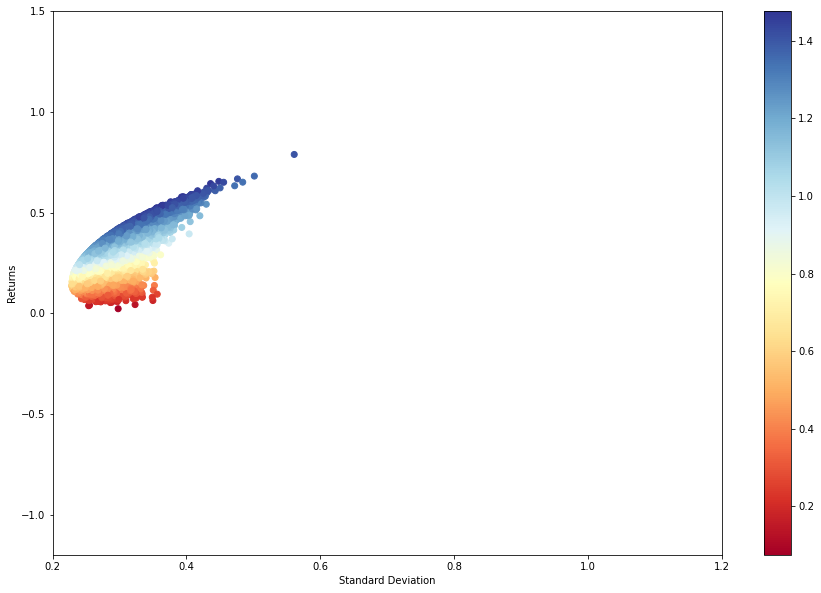

In [61]:
# scatter plot for long portfolio
# create scatter plot coloured by Sharpe Ratio

fig, ax=plt.subplots(figsize=(15,10))
ax.set(xlim=([0.2, 1.2]),ylim=([-1.2, 1.5]))
plt.scatter(results_frame_l.portfolio_std,results_frame_l.portfolio_return,c=results_frame_l.sharpe_ratio,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

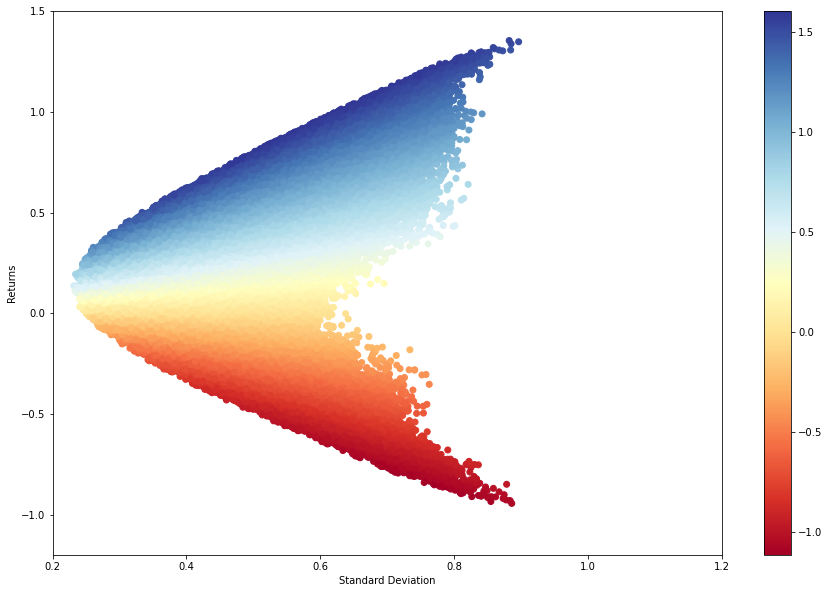

In [60]:
# scatter plot for short portfolio
# create scatter plot coloured by Sharpe Ratio

fig, ax=plt.subplots(figsize=(15,10))
ax.set(xlim=([0.2, 1.2]),ylim=([-1.2, 1.5]))
plt.scatter(results_frame_s.portfolio_std,results_frame_s.portfolio_return,c=results_frame_s.sharpe_ratio,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

**Frage 3:** Vergleichen Sie die beiden Graphen. Was fällt Ihnen auf?

Wenn shortselling etabliert wird (siehe unteres Streuungsdiagramm), steigt die Diversifikation der Portfolios hinsichtlich der sharpe ratio . Die Differenzen der Renditen der einzelnen Portfolios  gehen viel weiter auseinander mit zunehmender Standardabweichung. Daraus lässt sich schlussfolgern, dass mit shortselling größere positive aber auch negative Renditen mit den Portfolios erwirtschaftet werden können. Für Anleger kann dies interessant sein, wenn sie ihre Rendite vergrößern möchten. Zugleich erhöht dies aber auch das eingegangene Risiko.

Mit den Assets in unseren Portfolios und ohne shortselling wird fast ausschließlich eine positive Rendite erwirtschaft, wohingegen mit shortselling ein eher 60/40 Verhältnis zu Gunsten einer positiven Rendite besteht. Somit ist auch ohne Shortselling das Risiko der Portfolios geringer. Zudem ist die Streuungsbreite der sharp ratio ohne shortselling augenscheinlich kleiner.

->Die Simulation zeigt, dass es mit shortselling für den Anleger mehr Möglichkeiten gibt das Portfolio zu gestalten. Man kann eine höhere Volatilität erzielen, welche wiederum mit einer höheren Rendite entschädigt wird. Für risikofreudigere Anleger bietet es somit mehr Optionen, da man mehr Risiko eingehen kann und mehr Rendite erwarten kann.
